# 3D Computer Vision (2023/24)

## Exercise 1

Submitted by Group 14: 
- Tom Paßberg
- Iain Dorsch
- Daria Lekht
- Nihal Shaikh

Upload: 08.11.2023 (11:30)

**Deadline**: 21.11.2023 (23:59)

Please hand in a single **.zip** file named according to the pattern "**groupXX_exerciseX**" (e.g. group00_exercise9). The contents of the .zip should be as follows:
- folder named according to the pattern groupXX_exerciseX
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

I.e.
1. **unzip** the provided exerciseX.zip file
2. **rename** folder "exerciseX" according to the pattern "groupXX_exerciseX"
3. **solve** tasks inside .ipynb file
4. **export** notebook as .html (File > Download as > HTML)
5. **zip** folder groupXX_exerciseX
6. **submit** groupXX_exerciseX.zip

## Theory

### T1. Camera with lenses

#### (a)
Given a camera with a distance $L$ between the film and the lens, derive the mathematical relationship (formula) between the height $H_o$ of the object in front of the camera and the height $H_i$ of its image. Additionally, explain the intuition behind the relationship. Assume a thin lens.

#### Solution
- Similar triangles:
$\frac{y'}{D'} =\frac{y}{D} $ $\rightarrow$ $\frac{H_i}{L} =\frac{H_o}{D}$
- therefore $\frac{H_i}{H_o} =\frac{L}{D}$
- Interpretation: 
    - For the same distance to the lense $D$, a bigger object ($H_o$) has a bigger image ($H_i$)
    - (OR) The further the object of height $H_o$ is away from the lense ($D$), the smaller is its image $H_i$

### T2. Rotation 
An Object is roated around the x-axis by $90°$, then around the y-axis by $270°$, and finally around the z-axis by $180°$.

#### (a)
Derive the 3D Roation Matrix that executes the same transformation.<br/>
*Hint: the given values lead to 'nice' numbers.*

In [8]:
import numpy as np

A = np.array([[1,0,0], [0,0,-1], [0,1,0]])
B = np.array([[0,0,-1], [0,1,0], [1,0,0]])
C = np.array([[-1,0,0], [0,-1,0], [0,0,1]])

print(C @ B @ A)

[[0 1 0]
 [0 0 1]
 [1 0 0]]


$$
\left(\begin{array}{ccc} 
0 & 1 & 0\\
0 & 0 & 1\\
1 & 0 & 0
\end{array}\right)
$$

#### (b)
Assume the object is a sphere with a radius of 3.5. Explain how the radius will change after the transformation. 

Der Radius wird durch die Rotation nicht verändert.

#### (c)
What is the rotation matrix that transforms the object back to its original orientation?<br/>
*Hint: this should be very short*

$$
\left(\begin{array}{ccc} 
0 & 1 & 0\\
0 & 0 & 1\\
1 & 0 & 0
\end{array}\right) ^ T
= 
\left(\begin{array}{ccc} 
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0
\end{array}\right) 
$$

### T3. Transformation Chain

#### (a)
Why are homogeneous coordinates used for transforming points between coordinate systems?

Homogene Koordinaten werden verwendet um in der projektiven Geometrie Punkte darzustellen. Sie erlaubt Transformationen so wie Projektion effizent mithilfe von Matritzenmultiplikationen darzustellen. 

#### (b)
Describe the transformation chain for mapping a point from the world coordinate system to the pixel coordinate system of an intrinsically and extrinsically calibrated camera.  Use formulas and explain the intermediate steps in words.


* Represent Points as $P = [x,y,z,1]$
* Multiply with extrinsics $ E = [R \mid T]$ (rotation matrix $R$ and translation vector $T$) 
* $ P_{kamera} = EP $
* Normalization: $ P_{normalized} = [ \frac{x}{w},\frac{y}{w},\frac{z}{w} ] $
* Compensate for radial and tangential distortion if nessesary
* Multiply by intrinsics matrix $I$
* $ P_{pixel} = IP_{normalized} $
* Divide x and y coordinates by z

#### (c)
Describe the steps for modelling distortion. 

Radial distortion
* calculate distortion factor r for every point
* apply the distortion factor by multiplying the x and y coordinates by r

## Implementation

### I1. Distortion Modelling
The **./data/** directory contains images of a chessboard that were used for calibrating a camera with high radial distortion. The results of the calibration (intrinsics of the camera and extrinsics for each board) are stored in **./data/calib.mat**.

In [9]:
import os

import numpy as np
import cv2 as cv
import scipy.io as io
from PIL import Image, ImageDraw
from IPython.display import display
from matplotlib import pyplot as plt

#### (a)
Write a function that does the following:
- Draw any number of 2D pixel points onto an image

The inputs should be:
- A single image
- An Array of 3D world points
- Color of the points to be drawn

The output should be:
- An image with points drawn onto it

In [10]:
def draw_points(image, points, color):
    image_copy = image.copy()
    for point in points:
        cv.circle(image_copy, (int(point[0]), int(point[1])), 2, color, -1)
    return image_copy

Testet die draw function

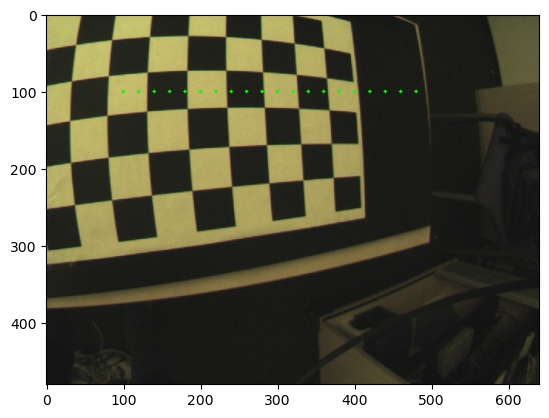

In [11]:
image = cv.imread("data/00000.jpg")
 
image_modified = draw_points(image, [[i,100] for i in range(100,500,20)], [0,255,0])

plt.imshow(cv.cvtColor(image_modified, cv.COLOR_BGR2RGB))
plt.show()

#### (b)
Write a function **project_points** that does the following:
- Convert 3D world points to 2D image points
- As an option: model radial distortions (using k1, k2, k5)

The inputs should be:
- Array of 3D world points
- Camera intrinsics
- Camera extrinsics
- Distortion coefficients (if needed)

The output should be:
- Array of 2D pixel coordinates

In [12]:
def project_points(world_points, intrinsics, extrinsics, distortion_coeffs=None):
    world_points = np.hstack((world_points, np.ones((len(world_points), 1))))
    camera_points = extrinsics @ world_points.T
    homogeneous_points = camera_points / camera_points[2, :]

    if distortion_coeffs is not None:
        # radial distortion berechen und auf homogene koordinaten anwenden
        r = sum(homogeneous_points[:2, :]**2)
        homogeneous_points[:2, :] *= 1 + distortion_coeffs[0]*r + distortion_coeffs[1]*r**2 + distortion_coeffs[4]*r**3

    pixel_points = intrinsics @ homogeneous_points
    image_points = pixel_points[:2,:] / pixel_points[2, :] 
    return image_points.T 

#### (c)
Write a function **project_and_draw** that does the following:
- Execute **project_points**
- Execute **draw_points**
- Save the result as an image file

The inputs should be:
- The data that is necessary to run your functions
- Needs to run on **all images** with a single call

In [13]:
def project_and_draw(images, world_points_list, intrinsics, extrinsics_list, output_dir, color, distortion_coeff=None):
    os.makedirs(name=output_dir, exist_ok=True)
    for i, (image, world_points, extrinsics) in enumerate(zip(images, world_points_list, extrinsics_list)):
        points = project_points(world_points, intrinsics, extrinsics, distortion_coeff)
        image = draw_points(image, points, color)
        cv.imwrite(filename=os.path.join(output_dir, f'{i:05d}.jpg'), img=image)

#### (d)
Run your **project_and_draw** function once without and once with distortion modelling. Then display the following:
- Your output for 00000.jpg **without any distortion modelling** in **red**
- Your output for 00000.jpg **with added radial distortion** (k1, k2, and k5) in **green**

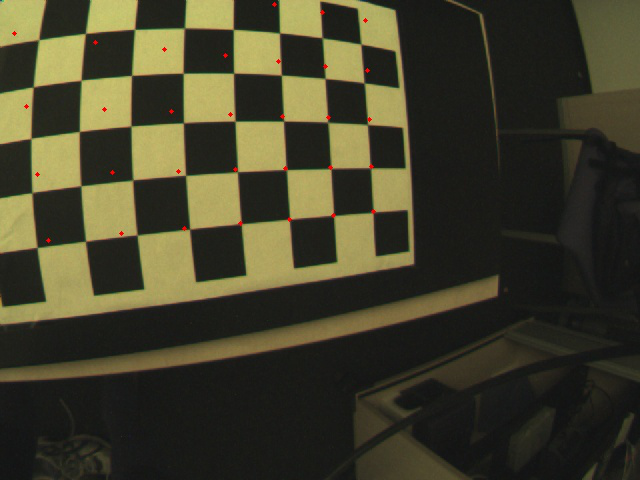

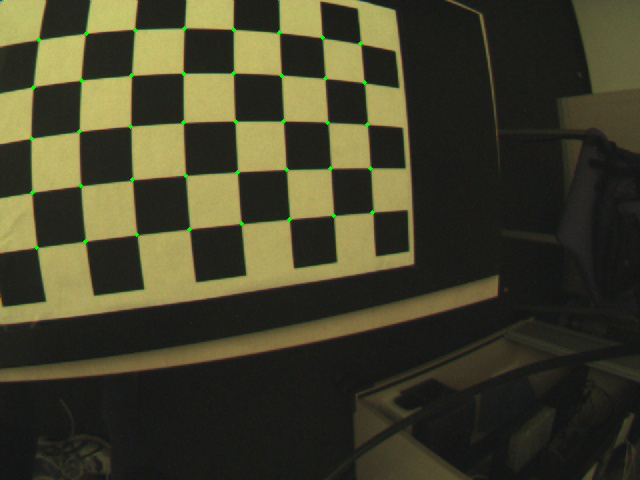

In [14]:
os.makedirs(name=f'results/no_distortion', exist_ok=True)
os.makedirs(name=f'results/distortion', exist_ok=True)

base_folder = './data/'

# Load the data
# There are 25 views/or images/ and 40 3D points per view
data = io.loadmat('./data/calib.mat')

# 3D points in the world coordinate system
x_3d_w = data['x_3d_w'] # shape=[25, 40, 3]

# Translation vector: as the world origin is seen from the camera coordinates
t_vecs = data['translation_vecs'] # shape=[25, 3, 1]

# Rotation matrices: converts coordinates from world to camera
rot_mats = data['rot_mats'] # shape=[25, 3, 3]

# Five distortion coefficients
dist_coef = data['distortion_params'] # shape=[5, 1]

# K matrix of the cameras
k_matrix = data['k_mat'] # shape=[3, 3]

# Images corresponding to the 3D points
imgs_list = [cv.imread(base_folder+str(i).zfill(5)+'.jpg') for i in range(t_vecs.shape[0])]
imgs = np.asarray(imgs_list) # shape=[25, 480, 640, 3]

#Call project_and_draw twice: once without and once with distortion modelling
project_and_draw(images=imgs, 
                 world_points_list=x_3d_w, 
                 intrinsics=k_matrix, 
                 extrinsics_list=[np.hstack((rot_mats[i], t_vecs[i])) for i in range(len(imgs))], 
                 output_dir='results/no_distortion',
                 color=[0,0,255],)

# Call project_and_draw with distortion modelling
project_and_draw(images=imgs, 
                 world_points_list=x_3d_w, 
                 intrinsics=k_matrix, 
                 extrinsics_list=[np.hstack((rot_mats[i], t_vecs[i])) for i in range(len(imgs))], 
                 output_dir='results/distortion',
                 color=[0,255,0],
                 distortion_coeff=dist_coef)

without_distortion = Image.open('results/no_distortion/00000.jpg')
display(without_distortion)

with_distortion = Image.open('results/distortion/00000.jpg')
display(with_distortion)